## Data Frame 

In [1]:
#http://www.andrewshamlet.net/2017/07/13/python-tutorial-stochastic-oscillator/

In [10]:
import pandas as pd
from pandas_datareader import data as web
from pandas import read_csv
from pandas import concat
import os.path
import datetime 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical


import matplotlib.pyplot as plt
%matplotlib inline

In [11]:

# Stochastic Oscilator %K
def STOK(close, low, high, n): 
 STOK = ((close - pd.Series.rolling(low, n).min()) / (pd.Series.rolling(high, n).max() - pd.Series.rolling(low, n).min())) * 100
 return STOK

# Stochastic Oscilator %D
def STOD(close, low, high, n):
    STOK = ((close - pd.Series.rolling(low, n).min()) / (pd.Series.rolling(high, n).max() - pd.Series.rolling(low, n).min())) * 100
    STOD = pd.Series.rolling(STOK, 3).mean()
    return STOD
    #STOD


In [3]:
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
   # rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
   #      pd.stats.moments.ewma(d, com=period-1, adjust=False)
    rs= pd.Series.ewm(u,com=period-1, min_periods=0,adjust=False,ignore_na=False).mean() / \
        pd.Series.ewm(d,com=period-1,min_periods=0,adjust=False,ignore_na=False).mean()
    return 100 - 100 / (1 + rs)

In [4]:

def getData(item):
    start = datetime.datetime(2016, 12, 21)
    end = datetime.datetime.now()
    #print( start,end) 
    file_path='./data/'+item +'.csv'
    if not os.path.exists(file_path):
        print("Empty set")
        df =web.DataReader(item,'yahoo',start,end)  
        df=df.round(2)
        
        df.to_csv('./data/' + item + '.csv')
        #df['Date']=pd.to_datetime(df['Date']) #important for sorting
        #df.set_index("Date",inplace=True)
        df.index.name = 'Date'
    else:
        print("Read from file")  
        df = read_csv(file_path)
        df['Date']=pd.to_datetime(df['Date']) #important for sorting
        df.set_index("Date",inplace=True)

        #end = datetime.datetime.now()
        lastDate=df.index[df.shape[0]-1] #last recorded day
        d1 = lastDate #datetime.datetime.strptime(lastDate, "%Y-%m-%d")  
        #d1 = datetime.datetime.strptime(lastDate)
        #print(d1,end )
        if( d1 < end - datetime.timedelta(days=2)): # dont update on Sat or Sun
            print("Updating")  
            d2 = lastDate + datetime.timedelta(days=1)
            #print(d2,end )
            df1 =web.DataReader(item,'yahoo',d2,end)  
            updateDate=df1.index[df1.shape[0]-1]
            print(updateDate , d1)
            if (updateDate !=  d1): #yahoo gives unwanted records
                df1=df1.round(2)
                df=pd.concat([df,df1])
                df.index= pd.to_datetime(df.index, format="%Y-%m-%d") # drop time 
                df.to_csv('./data/' + item + '.csv')
            else:
                print("No need to update")
    return df


def cleanData( df):
    # drop Close and Volume, keep Adj Close
    df1 = df.drop('Close', 1)
    df1 = df1.drop('Volume', 1)
    df1.rename(columns={'Adj Close': 'Close', 'oldName2': 'newName2'}, inplace=True)
    return df1



### getData('DJI')

In [8]:
itemname='GM'
dframe=getData(itemname)
dframe=cleanData(dframe)
djiframe=getData('DJI')
djiframe=cleanData(djiframe)
#dframe=dframe.join(djiframe, lsuffix='_left', rsuffix='_right')
dframe=dframe.join(djiframe , rsuffix='_right')
dframe.tail()

Read from file
Updating
2017-12-01 00:00:00 2017-12-01 00:00:00
No need to update
Read from file
Updating


RemoteDataError: Unable to read URL: https://query1.finance.yahoo.com/v7/finance/download/DJI?period1=1512190800&period2=1512363599&interval=1d&events=history&crumb=oC4z%5Cu002F4RD1oK

In [9]:
#yahoo problem - even if asked for 2017/11/25 ig gives back 2017/11/25 on sunday 11/26
d2=datetime.datetime(2017, 11, 25)
end = datetime.datetime.now()
df=web.DataReader(itemname,'yahoo',d2,end)  
df


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-27,44.470001,44.490002,43.880001,44.169998,44.169998,8652600
2017-11-28,44.349998,45.080002,44.139999,44.919998,44.919998,15933300
2017-11-29,45.099998,45.349998,43.790001,43.810001,43.810001,19442900
2017-11-30,44.000000,44.529999,42.700001,43.090000,43.090000,32515100
2017-12-01,43.189999,43.250000,41.869999,42.790001,42.790001,19298800


In [215]:
#from sklearn.preprocessing import LabelEncoder
def engFeatures(df):
    df['%K'] = STOK(df['Close'], df['Low'], df['High'], 14)
    df['%D'] = STOD(df['Close'], df['Low'], df['High'], 14)
    df['Avg5'] =pd.Series.rolling(df['Close'],5).mean()
    df['Avg10'] =pd.Series.rolling(df['Close'],10).mean()
    df['RSI14'] = RSI(df['Close'],14)
    df['RSI7'] = RSI(df['Close'],7)
    df.sort_index(ascending=False,inplace=True)
    df['Rise'] = (  pd.Series.rolling(df['Close'],5).max()-df['Close'] >df['Close']*0.04)*1
    df.sort_index(ascending=True,inplace=True)
    return df

In [216]:
fullFrame=engFeatures(dframe)
fullFrame.head()

,Open,High,Low,Close,Open_right,High_right,Low_right,Close_right,%K,%D,Avg5,Avg10,RSI14,RSI7,Rise
Date,,,,,,,,,,,,,,,
2016-12-21,36.50,36.69,36.35,35.29,19969.0,19986.6,19942.1,19942.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2016-12-22,36.29,36.40,35.63,34.59,19922.7,19933.8,19882.2,19918.9,NaN,NaN,NaN,NaN,NaN,NaN,0
2016-12-23,35.83,35.87,35.54,34.59,19908.6,19933.8,19899.1,19933.8,NaN,NaN,NaN,NaN,NaN,NaN,0
2016-12-27,35.80,35.93,35.50,34.44,19943.5,19980.2,19939.8,19945.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2016-12-28,35.74,35.80,35.13,34.06,19964.3,19981.1,19827.3,19833.7,NaN,NaN,34.594,NaN,NaN,NaN,1


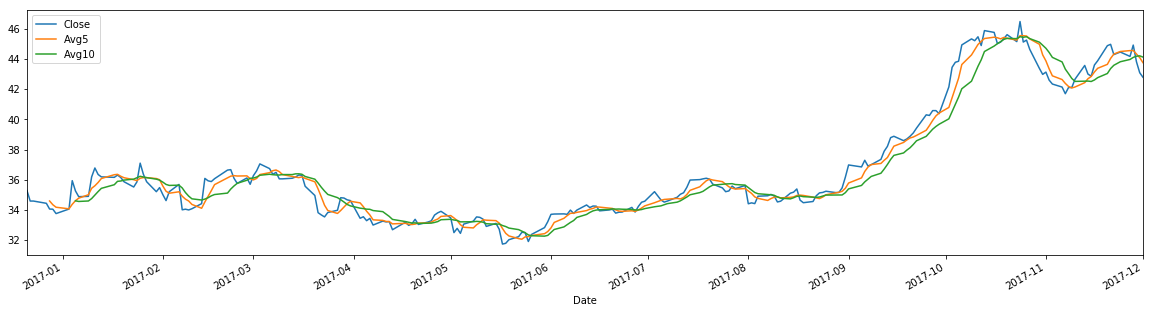

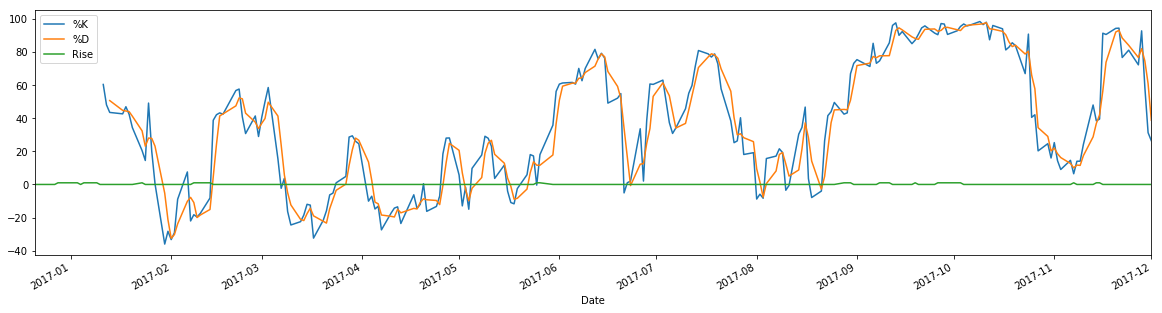

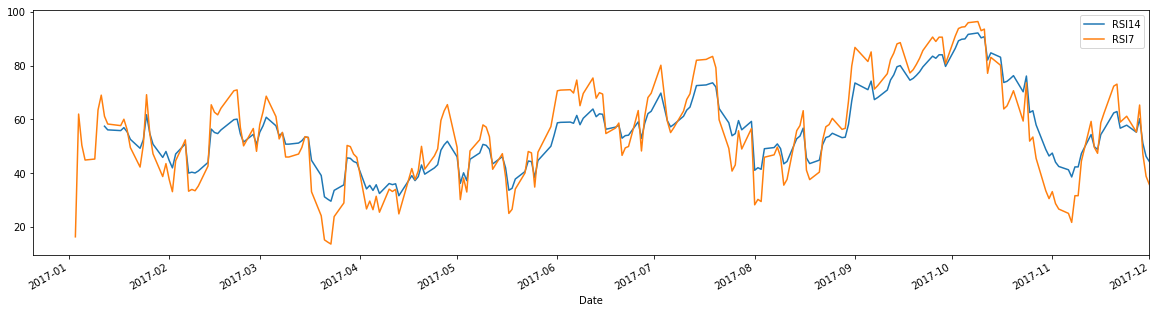

In [217]:
fullFrame.plot(y=['Close','Avg5','Avg10'], figsize = (20, 5))
fullFrame.plot(y=['%K', '%D','Rise'], figsize = (20, 5))
fullFrame.plot(y=['RSI14', 'RSI7'], figsize = (20, 5))

In [218]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

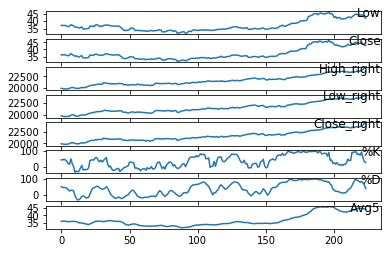

In [219]:
from matplotlib import pyplot

fullFrame.dropna(inplace=True)

values = fullFrame.values
# specify columns to plot
groups = [ 2, 3, 5, 6, 7,8,9,10]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(fullFrame.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [220]:
values[1]

array([    37.34      ,     37.69      ,     37.17      ,     36.16      ,
        19848.8       ,  19883.        ,  19775.3       ,  19826.8       ,
           42.69340974,     44.79465138,     36.334     ,     35.671     ,
           55.83610009,     57.68272285,      0.        ])

In [221]:
'''values = np.array([[  10, 20, 30, 40, 50, 60, 0 ],
                  [  11, 21, 32, 43, 54, 65 ,0 ],
                  [  12, 22, 33, 44, 55, 66 ,1 ],
                  [  13, 23, 34, 45, 56, 67 ,1 ]])
values[1]'''

'values = np.array([[  10, 20, 30, 40, 50, 60, 0 ],\n                  [  11, 21, 32, 43, 54, 65 ,0 ],\n                  [  12, 22, 33, 44, 55, 66 ,1 ],\n                  [  13, 23, 34, 45, 56, 67 ,1 ]])\nvalues[1]'

In [5]:
#from sklearn.preprocessing import MinMaxScaler

def rescale( df):
    df.dropna(inplace=True)
    values = df.values
    # ensure all data is float
    values = values.astype('float')
    #drop columns to simplify test
    timesteps=3
    features = values.shape[1]-1
    # normalize features
    scaler = MinMaxScaler()
    #scaled = scaler.fit_transform(values)
    scaled = values #scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled,timesteps, 1)
    # drop columns we don't want to predict
    #reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17,18,19,20]], axis=1, inplace=True)
    reframed= pd.DataFrame(reframed)
    return reframed
#print(reframed.head())
#reframed.iloc[0]

In [6]:
reframed=rescale(fullFrame)
reframed.iloc[0]

NameError: name 'fullFrame' is not defined

In [224]:
values.shape

(224, 15)

In [226]:
# split into train and test sets
from keras.utils.np_utils import to_categorical
import numpy 

values = reframed.values
n_train_size = values.shape[0]-50
train = values[:, :]
test = values[n_train_size:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], to_categorical(train[:, -1])
#train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], to_categorical(test[:, -1])
#test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = numpy.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1 ))
test_X = numpy.reshape(test_X, (test_X.shape[0], test_X.shape[1],1))

#train_X = train_X.reshape((1,train_X.shape[0], train_X.shape[1]))
#test_X = test_X.reshape((1,timesteps, features)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
#print(train_X[0:1,:])

(221, 59, 1) (221, 2) (50, 59, 1) (50, 2)


In [227]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
# design network

def buildmodel( df):
    model = Sequential()

    #this is good .92
    model.add(LSTM(20, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(20))
    model.add(Dense(8, input_dim=3, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))

    '''#this is good .89
    model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(8, input_dim=3, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))'''

    '''#this is good .88
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(8, input_dim=3, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))'''

    #Dense expects a 2-dimensional input (batch_size, features), 
    #whereas the output of LSTM with return_sequences is 3 dimensional (batch_size, timesteps, features).

    #stacked --good acc =0.843
    '''model.add(LSTM(4, input_shape=(43, 1)))
    model.add(Dense(2, activation='sigmoid'))
    print(model.summary())'''

    '''model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))'''


    #model.compile(loss='mae', optimizer='adam')
    # it should be categorical
    #model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

themodel=buildmodel()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 59, 20)            1760      
_________________________________________________________________
lstm_4 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
Total params: 5,226
Trainable params: 5,226
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
# fit network
history=themodel.fit(train_X, train_y, epochs=100, batch_size=1, verbose=2)
# plot history
'''pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()'''

Epoch 1/100
78s - loss: 0.3499 - acc: 0.8922
Epoch 2/100
73s - loss: 0.3219 - acc: 0.8933
Epoch 3/100
73s - loss: 0.2914 - acc: 0.8933
Epoch 4/100
72s - loss: 0.2715 - acc: 0.8933
Epoch 5/100
73s - loss: 0.2625 - acc: 0.8956
Epoch 6/100
72s - loss: 0.2585 - acc: 0.8944
Epoch 7/100
73s - loss: 0.2490 - acc: 0.9100
Epoch 8/100
73s - loss: 0.2517 - acc: 0.9111
Epoch 9/100
72s - loss: 0.2534 - acc: 0.9078
Epoch 10/100
73s - loss: 0.2473 - acc: 0.9122
Epoch 11/100
72s - loss: 0.2457 - acc: 0.9156
Epoch 12/100
77s - loss: 0.2444 - acc: 0.9078
Epoch 13/100
78s - loss: 0.2438 - acc: 0.9100
Epoch 14/100
78s - loss: 0.2354 - acc: 0.9133
Epoch 15/100
77s - loss: 0.2410 - acc: 0.9089
Epoch 16/100
77s - loss: 0.2423 - acc: 0.9133
Epoch 17/100
80s - loss: 0.2367 - acc: 0.9156
Epoch 18/100
90s - loss: 0.2350 - acc: 0.9144
Epoch 19/100
82s - loss: 0.2369 - acc: 0.9100
Epoch 20/100
79s - loss: 0.2339 - acc: 0.9200
Epoch 21/100
79s - loss: 0.2295 - acc: 0.9156
Epoch 22/100
88s - loss: 0.2287 - acc: 0.91

"pyplot.plot(history.history['loss'], label='train')\npyplot.plot(history.history['val_loss'], label='test')\npyplot.legend()\npyplot.show()"

In [65]:
# serialize model to JSON
model_json = themodel.to_json()
with open("./data/" + itemname + "_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
themodel.save_weights("./data/" + itemname + "_model.h5")
print("Saved model to disk")


Saved model to disk


In [66]:
# later...
# load json and create model
from keras.models import model_from_json

json_file = open('./data/' + itemname +'_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('./data/' + itemname +'_model.h5')
print("Loaded model from disk")
# evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) #61.29
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate( test_X, test_y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 84.06%


In [67]:
# make a prediction
#test_X.shape
yhat = model.predict(test_X)
#yhat = model.predict(train_X)
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [68]:
#Reverse categorical
from numpy import argmax
argmax(yhat,axis=1)

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [69]:
argmax(test_y,axis=1)


array([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [81]:
yhat[10]
argmax(yhat[10])

1

In [82]:
values[10]

array([  3.59700010e+01,   3.64700010e+01,   3.54199980e+01,
         3.61100010e+01,   3.09206450e+01,   3.12480000e+07,
         3.77155254e+01,   2.10606866e+01,   3.55300006e+01,
         3.60490002e+01,   0.00000000e+00,   3.59100000e+01,
         3.59199980e+01,   3.46199990e+01,   3.49000020e+01,
         2.98845330e+01,   4.32684000e+07,   1.21076485e+01,
         2.27258649e+01,   3.54600010e+01,   3.58630006e+01,
         0.00000000e+00,   3.52200010e+01,   3.57400020e+01,
         3.51899990e+01,   3.52500000e+01,   3.01842380e+01,
         2.37724000e+07,   2.14975656e+01,   2.37735798e+01,
         3.53460010e+01,   3.57070005e+01,   0.00000000e+00,
         3.54900020e+01,   3.56500020e+01,   3.51300010e+01,
         3.55600010e+01,   3.04496880e+01,   2.33009000e+07,
         3.20000000e+01,   2.18684047e+01,   3.54100008e+01,
         3.56280008e+01,   0.00000000e+00])

In [59]:
values[10,:]

array([ 0.03852263,  0.03150303,  0.03530217,  0.02953714,  0.03021936,
        0.32847463,  0.4099467 ,  0.31312716,  0.01433132,  0.00343808,  0.        ])

In [68]:
df.values[10,:]

array([  7.44828570e+01,   7.47042850e+01,   7.39114300e+01,
         7.42399980e+01,   6.94897990e+01,   9.25701000e+07,
         4.09946700e+01,   3.35373005e+01,   7.30028566e+01,
         7.30461419e+01,   0.00000000e+00])

In [ ]:
def custom_index(array, compare_function):

  for i, v in enumerate(array):

    if compare_function(v):

      return i